# पीटर और भेड़िया: रिइनफोर्समेंट लर्निंग प्राइमर

इस ट्यूटोरियल में, हम सीखेंगे कि रिइनफोर्समेंट लर्निंग को पथ खोजने की समस्या पर कैसे लागू किया जाए। यह सेटिंग रूसी संगीतकार [सर्गेई प्रोकोफिएव](https://en.wikipedia.org/wiki/Sergei_Prokofiev) की संगीत परीकथा [पीटर और भेड़िया](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) से प्रेरित है। यह कहानी युवा अग्रणी पीटर के बारे में है, जो बहादुरी से अपने घर से बाहर निकलकर जंगल के खुले क्षेत्र में भेड़िया का पीछा करने जाता है। हम मशीन लर्निंग एल्गोरिदम को प्रशिक्षित करेंगे जो पीटर को आसपास के क्षेत्र का पता लगाने और एक आदर्श नेविगेशन मानचित्र बनाने में मदद करेंगे।

सबसे पहले, चलिए कुछ उपयोगी लाइब्रेरी आयात करते हैं:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## सुदृढीकरण शिक्षण का अवलोकन

**सुदृढीकरण शिक्षण** (RL) एक शिक्षण तकनीक है जो हमें किसी **पर्यावरण** में एक **एजेंट** के इष्टतम व्यवहार को कई प्रयोगों के माध्यम से सीखने की अनुमति देती है। इस पर्यावरण में एजेंट का कुछ **लक्ष्य** होना चाहिए, जिसे एक **इनाम फ़ंक्शन** द्वारा परिभाषित किया जाता है।

## पर्यावरण

सरलता के लिए, चलिए पीटर की दुनिया को `चौड़ाई` x `ऊंचाई` आकार के एक वर्ग बोर्ड के रूप में मानते हैं। इस बोर्ड की प्रत्येक सेल निम्नलिखित में से कोई एक हो सकती है:
* **जमीन**, जिस पर पीटर और अन्य जीव चल सकते हैं
* **पानी**, जिस पर आप स्पष्ट रूप से नहीं चल सकते
* **एक पेड़** या **घास** - एक जगह जहां आप थोड़ा आराम कर सकते हैं
* **एक सेब**, जो कुछ ऐसा है जिसे पीटर खुशी से ढूंढेगा ताकि वह खुद को खिला सके
* **एक भेड़िया**, जो खतरनाक है और इससे बचना चाहिए

पर्यावरण के साथ काम करने के लिए, हम एक क्लास `Board` परिभाषित करेंगे। इस नोटबुक को बहुत अधिक जटिल न बनाने के लिए, हमने बोर्ड के साथ काम करने वाले सभी कोड को एक अलग `rlboard` मॉड्यूल में स्थानांतरित कर दिया है, जिसे हम अब आयात करेंगे। आप इस मॉड्यूल के अंदर देख सकते हैं ताकि कार्यान्वयन के आंतरिक विवरण के बारे में अधिक जानकारी प्राप्त कर सकें।


In [2]:
from rlboard import *

अब चलो एक यादृच्छिक बोर्ड बनाते हैं और देखते हैं कि यह कैसा दिखता है:


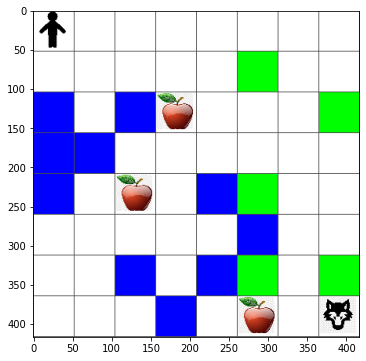

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## क्रियाएँ और नीति

हमारे उदाहरण में, पीटर का लक्ष्य एक सेब ढूंढना होगा, जबकि उसे भेड़िये और अन्य बाधाओं से बचना होगा। ऐसा करने के लिए, वह इधर-उधर चल सकता है जब तक कि उसे सेब न मिल जाए। इसलिए, किसी भी स्थिति में वह निम्नलिखित क्रियाओं में से एक चुन सकता है: ऊपर, नीचे, बाएँ और दाएँ। हम इन क्रियाओं को एक डिक्शनरी के रूप में परिभाषित करेंगे और उन्हें संबंधित समन्वय परिवर्तनों के जोड़ों से मैप करेंगे। उदाहरण के लिए, दाएँ (`R`) की ओर बढ़ना `(1,0)` के जोड़े से मेल खाएगा।


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

हमारे एजेंट (पीटर) की रणनीति को एक विशेष **पॉलिसी** द्वारा परिभाषित किया गया है। चलिए सबसे सरल पॉलिसी, जिसे **रैंडम वॉक** कहा जाता है, पर विचार करते हैं।

## रैंडम वॉक

सबसे पहले, चलिए रैंडम वॉक रणनीति को लागू करके अपनी समस्या का समाधान करते हैं।


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

चलो रैंडम वॉक प्रयोग को कई बार चलाते हैं और लिए गए औसत कदमों की संख्या देखते हैं:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## पुरस्कार फ़ंक्शन

हमारी नीति को अधिक बुद्धिमान बनाने के लिए, हमें यह समझना होगा कि कौन से कदम दूसरों की तुलना में "बेहतर" हैं।


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## क्यू-लर्निंग

एक क्यू-टेबल या बहु-आयामी ऐरे बनाएं। चूंकि हमारे बोर्ड का आकार `width` x `height` है, हम क्यू-टेबल को एक numpy ऐरे के रूप में `width` x `height` x `len(actions)` के आकार के साथ दर्शा सकते हैं:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Q-टेबल को बोर्ड पर तालिका को विज़ुअलाइज़ करने के लिए प्लॉट फ़ंक्शन में पास करें:


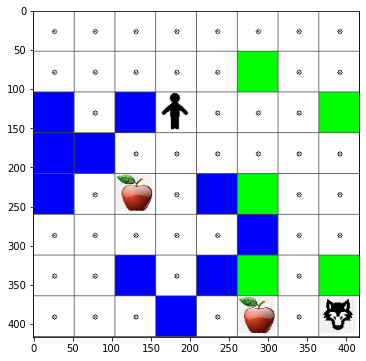

In [9]:
m.plot(Q)

## क्यू-लर्निंग का सार: बेलमैन समीकरण और लर्निंग एल्गोरिदम

हमारे लर्निंग एल्गोरिदम के लिए एक छद्म-कोड लिखें:

* सभी राज्यों और क्रियाओं के लिए Q-टेबल Q को समान संख्याओं से प्रारंभ करें  
* लर्निंग दर $\alpha\leftarrow 1$ सेट करें  
* सिमुलेशन को कई बार दोहराएं  
   1. किसी भी रैंडम स्थिति से शुरू करें  
   1. दोहराएं  
        1. स्थिति $s$ पर एक क्रिया $a$ चुनें  
        2. नई स्थिति $s'$ पर जाने के लिए क्रिया को निष्पादित करें  
        3. यदि हम खेल के अंत की स्थिति पर पहुँचते हैं, या कुल इनाम बहुत कम हो जाता है - सिमुलेशन से बाहर निकलें  
        4. नई स्थिति पर इनाम $r$ की गणना करें  
        5. बेलमैन समीकरण के अनुसार Q-फंक्शन को अपडेट करें: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$  
        6. $s\leftarrow s'$  
        7. कुल इनाम को अपडेट करें और $\alpha$ को घटाएं।  

## एक्सप्लॉइट बनाम एक्सप्लोर

सबसे अच्छा तरीका है कि अन्वेषण (exploration) और दोहन (exploitation) के बीच संतुलन बनाए रखें। जैसे-जैसे हम अपने परिवेश के बारे में अधिक सीखते हैं, हम अधिक संभावना से इष्टतम मार्ग का अनुसरण करेंगे, लेकिन समय-समय पर अनदेखे रास्ते को चुनना भी महत्वपूर्ण है।  

## पायथन कार्यान्वयन

अब हम लर्निंग एल्गोरिदम को कार्यान्वित करने के लिए तैयार हैं। इससे पहले, हमें एक ऐसा फ़ंक्शन भी चाहिए जो Q-टेबल में दिए गए मनमाने संख्याओं को संबंधित क्रियाओं के लिए संभावनाओं के वेक्टर में परिवर्तित कर सके:  


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

हम मूल वेक्टर में थोड़ा सा `eps` जोड़ते हैं ताकि प्रारंभिक स्थिति में, जब वेक्टर के सभी घटक समान हों, शून्य से विभाजन से बचा जा सके।

वास्तविक शिक्षण एल्गोरिदम जिसे हम 5000 प्रयोगों के लिए चलाएंगे, जिसे **epochs** भी कहा जाता है:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

इस एल्गोरिथ्म को निष्पादित करने के बाद, Q-टेबल को उन मानों के साथ अपडेट किया जाना चाहिए जो प्रत्येक चरण में विभिन्न क्रियाओं की आकर्षकता को परिभाषित करते हैं। यहां तालिका को विज़ुअलाइज़ करें:


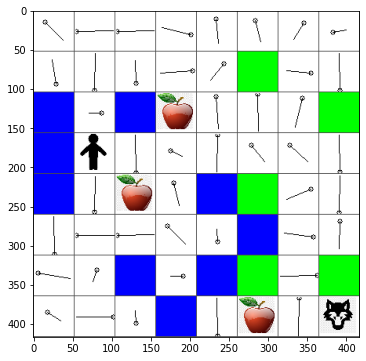

In [12]:
m.plot(Q)

## नीति की जांच करना

चूंकि Q-Table प्रत्येक स्थिति में प्रत्येक क्रिया की "आकर्षकता" को सूचीबद्ध करता है, इसे हमारे संसार में कुशल नेविगेशन को परिभाषित करने के लिए उपयोग करना काफी आसान है। सबसे सरल स्थिति में, हम बस उस क्रिया का चयन कर सकते हैं जो Q-Table में सबसे उच्च मान से संबंधित हो:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

यदि आप ऊपर दिए गए कोड को कई बार आज़माते हैं, तो आप देख सकते हैं कि कभी-कभी यह बस "रुक" जाता है, और आपको इसे रोकने के लिए नोटबुक में STOP बटन दबाना पड़ता है।

> **कार्य 1:** `walk` फ़ंक्शन को संशोधित करें ताकि पथ की अधिकतम लंबाई को एक निश्चित संख्या (जैसे, 100) तक सीमित किया जा सके, और ऊपर दिया गया कोड समय-समय पर इस मान को वापस करे।

> **कार्य 2:** `walk` फ़ंक्शन को संशोधित करें ताकि यह उन स्थानों पर वापस न जाए जहाँ यह पहले से ही जा चुका है। यह `walk` को लूपिंग से रोकेगा, लेकिन एजेंट अभी भी ऐसी स्थिति में "फंस" सकता है जहाँ से वह बाहर नहीं निकल सकता।


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


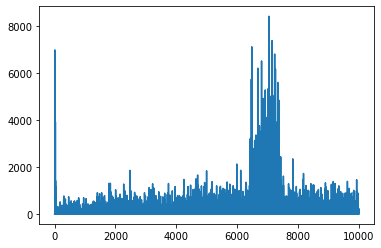

In [15]:
plt.plot(lpath)

जो हम यहाँ देख रहे हैं, वह यह है कि शुरुआत में औसत पथ की लंबाई बढ़ गई। इसका कारण संभवतः यह है कि जब हमें पर्यावरण के बारे में कुछ भी पता नहीं होता - तो हम खराब स्थितियों, पानी या भेड़िये में फंसने की संभावना रखते हैं। जैसे-जैसे हम अधिक सीखते हैं और इस ज्ञान का उपयोग करना शुरू करते हैं, हम पर्यावरण का अधिक समय तक अन्वेषण कर सकते हैं, लेकिन हमें अभी भी यह अच्छी तरह से पता नहीं होता कि सेब कहाँ हैं।

एक बार जब हम पर्याप्त सीख लेते हैं, तो एजेंट के लिए लक्ष्य प्राप्त करना आसान हो जाता है, और पथ की लंबाई कम होने लगती है। हालांकि, हम अभी भी अन्वेषण के लिए खुले हैं, इसलिए हम अक्सर सबसे अच्छे पथ से भटक जाते हैं और नए विकल्पों का अन्वेषण करते हैं, जिससे पथ इष्टतम से अधिक लंबा हो जाता है।

इस ग्राफ पर जो हम और भी देख सकते हैं, वह यह है कि किसी बिंदु पर लंबाई अचानक बढ़ गई। यह प्रक्रिया की अनिश्चित प्रकृति को दर्शाता है, और यह कि हम किसी बिंदु पर Q-Table गुणांक को "खराब" कर सकते हैं, उन्हें नए मानों से अधिलेखित करके। इसे आदर्श रूप से सीखने की दर को कम करके न्यूनतम किया जाना चाहिए (यानी प्रशिक्षण के अंत में हम केवल Q-Table मानों को एक छोटे मान से समायोजित करते हैं)।

कुल मिलाकर, यह याद रखना महत्वपूर्ण है कि सीखने की प्रक्रिया की सफलता और गुणवत्ता काफी हद तक पैरामीटर पर निर्भर करती है, जैसे सीखने की दर, सीखने की दर में कमी और छूट कारक। इन्हें अक्सर **हाइपरपैरामीटर** कहा जाता है, ताकि उन्हें **पैरामीटर** से अलग किया जा सके जिन्हें हम प्रशिक्षण के दौरान अनुकूलित करते हैं (जैसे Q-Table गुणांक)। सबसे अच्छे हाइपरपैरामीटर मानों को खोजने की प्रक्रिया को **हाइपरपैरामीटर अनुकूलन** कहा जाता है, और यह एक अलग विषय के योग्य है।


## अभ्यास
#### एक अधिक यथार्थवादी पीटर और भेड़िया की दुनिया

हमारी स्थिति में, पीटर लगभग बिना थके या भूखे हुए इधर-उधर घूम सकता था। एक अधिक यथार्थवादी दुनिया में, उसे समय-समय पर बैठकर आराम करना होगा और खुद को खिलाना भी होगा। आइए निम्नलिखित नियमों को लागू करके अपनी दुनिया को अधिक यथार्थवादी बनाते हैं:

1. एक स्थान से दूसरे स्थान पर जाने से, पीटर की **ऊर्जा** कम होती है और उसे कुछ **थकान** होती है।
2. पीटर सेब खाकर अधिक ऊर्जा प्राप्त कर सकता है।
3. पीटर पेड़ के नीचे या घास पर आराम करके थकान से छुटकारा पा सकता है (यानी बोर्ड के उस स्थान पर चलकर जाना जहां पेड़ या घास हो - हरा क्षेत्र)।
4. पीटर को भेड़िये को ढूंढकर मारना होगा।
5. भेड़िये को मारने के लिए, पीटर के पास निश्चित स्तर की ऊर्जा और थकान होनी चाहिए, अन्यथा वह लड़ाई हार जाएगा।

ऊपर दिए गए इनाम फ़ंक्शन को खेल के नियमों के अनुसार संशोधित करें, सुदृढीकरण सीखने का एल्गोरिदम चलाएं ताकि खेल जीतने की सबसे अच्छी रणनीति सीखी जा सके, और यादृच्छिक चाल के परिणामों की तुलना अपने एल्गोरिदम के साथ करें, खेल जीतने और हारने की संख्या के संदर्भ में।

> **Note**: आपको इसे काम करने के लिए हाइपरपैरामीटर को समायोजित करने की आवश्यकता हो सकती है, विशेष रूप से epochs की संख्या। क्योंकि खेल (भेड़िये से लड़ाई) की सफलता एक दुर्लभ घटना है, आप अपेक्षा कर सकते हैं कि प्रशिक्षण का समय काफी लंबा होगा।



---

**अस्वीकरण**:  
यह दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) का उपयोग करके अनुवादित किया गया है। जबकि हम सटीकता सुनिश्चित करने का प्रयास करते हैं, कृपया ध्यान दें कि स्वचालित अनुवाद में त्रुटियां या अशुद्धियां हो सकती हैं। मूल भाषा में उपलब्ध मूल दस्तावेज़ को प्रामाणिक स्रोत माना जाना चाहिए। महत्वपूर्ण जानकारी के लिए, पेशेवर मानव अनुवाद की सिफारिश की जाती है। इस अनुवाद के उपयोग से उत्पन्न किसी भी गलतफहमी या गलत व्याख्या के लिए हम जिम्मेदार नहीं हैं।
